In [113]:
from __future__ import print_function
import numpy as np
import PIL.Image as Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [114]:
file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
file_path_2 = '/users/jamesthomas/MachineLearning_Python/Lab2/'

df = pd.read_csv(file_path_2+'male_PA_single_disease.csv')
new_df = df[['Image Index','Finding Labels']]
new_df.groupby(['Finding Labels'])

In [115]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
1,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
2,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168,0.168
3,00000118_011.png,Pneumothorax,11,118,073Y,M,PA,2774,2991,0.143,0.143
4,00000165_008.png,No Finding,8,165,078Y,M,PA,2940,2900,0.143,0.143


In [116]:
# check if the frame contains 'No Finding' True if the patient was sick, False if not
y_sick = ~df['Finding Labels'].str.contains('No Finding')

# now check for pneumonia, True if patient has pneumonia, False else
y_pneumonia = df['Finding Labels'].str.contains('Pneumonia')


# now make target for all diseases

disease_list = ['Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly', 'Pleural_Thickening',
                'Consolidation', 'Pneumothorax', 'Mass', 'Nodule', 'Atelectasis', 'Effusion', 'Infiltration', 'No Finding']

def disease_to_list(string, full_results = disease_list):
    '''Function to generate a list of the different diseases each patient has
    Inputs
    string: the string containing the diseases, ie df['Finding Labels']
    full_results: the list of all possible diseases used for the indices in the resulting list
    Returns
    list: a list with False if the patient didn't have the disease and True if the patient did. Indices based on full_results
    '''
    diseases = string.split('|')
    result = [False]*len(full_results)
    
    for d in diseases:
        result[full_results.index(d)] = True
    return result

y_all_l = df['Finding Labels'].apply(disease_to_list) # series version of .apply(). This returns a pd.series of lists
y_all = pd.DataFrame(y_all_l.tolist(), columns = disease_list) # convert to a pd.dataframe

# now check that the totals match kaggle https://www.kaggle.com/nih-chest-xrays/sample
y_all.sum(axis=0)

Hernia                   2
Pneumonia                5
Fibrosis                16
Edema                    1
Emphysema               17
Cardiomegaly            14
Pleural_Thickening      27
Consolidation           10
Pneumothorax            25
Mass                    39
Nodule                  48
Atelectasis             71
Effusion                58
Infiltration           147
No Finding            1082
dtype: int64

In [117]:
from sklearn.model_selection import train_test_split

dat_train, dat_test, y_train, y_test = train_test_split(df, y_sick, test_size=0.2, random_state=42, stratify=y_pneumonia)

working on train 1248, 00024040_000.png, 15.12


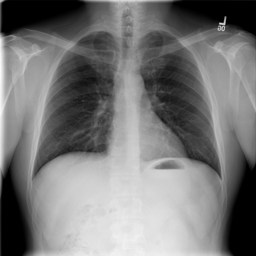

In [118]:
X_test = np.empty([len(dat_test), size, size, 1], dtype=np.float32) # preallocate
X_train = np.empty([len(dat_train), size, size, 1], dtype=np.float32) # num_images, img_width, img_height, num_channels

X_test[:,:,:,0]=1
X_train[:,:,:,0]=1

index = 0
t_start = time.time()
for name in dat_test['Image Index']:
    clear_output(wait=True)
    print('working on test {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(file_path+name)
    display(img)
    X_test[index,:,:,0] = np.array(img)/255.0-0.5
    index+=1

index = 0
t_start = time.time()
for name in dat_train['Image Index']:
    clear_output(wait=True)
    print('working on train {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(file_path+name)
    display(img)
    X_train[index,:,:,0] = np.array(img)/255.5-0.5
    index+=1

In [119]:
# the datagen 
# from class: https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

In [120]:
# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

visible = Input(shape=(size,size,1))

conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(16, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(16, kernel_size=3, activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1, kernel_size=3, activation='relu',name='final_conv')(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool5)
hidden1 = Dense(20, activation='relu')(flat)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 16)        0         
__________

In [121]:
from keras.utils import to_categorical
import tensorflow as tf
#print(y_train.shape)
#print(y_test.shape)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                        epochs=5, verbose=1,
                        validation_data=(X_test,y_test)
                        )

(1249,)
(313,)
Epoch 1/5
39/39 [==============================] - 44s 1s/step - loss: 0.6508 - acc: 0.6711 - val_loss: 0.6197 - val_acc: 0.6965
Epoch 2/5
39/39 [==============================] - 19s 477ms/step - loss: 0.6128 - acc: 0.6969 - val_loss: 0.6147 - val_acc: 0.6965
Epoch 3/5
39/39 [==============================] - 19s 475ms/step - loss: 0.6019 - acc: 0.6993 - val_loss: 0.7740 - val_acc: 0.6965
Epoch 4/5
39/39 [==============================] - 19s 479ms/step - loss: 0.6173 - acc: 0.6977 - val_loss: 0.6149 - val_acc: 0.6965
Epoch 5/5
39/39 [==============================] - 20s 516ms/step - loss: 0.6115 - acc: 0.6985 - val_loss: 0.6181 - val_acc: 0.6965


In [142]:
heat_map_model = Model(inputs=model.input, outputs=model.get_layer('final_conv').output)

heat_map_data = heat_map_model.predict(X_train)

In [143]:
heat_map_data = np.array([imresize(np.reshape(x,(12,12)), size=(256,256), interp='nearest') for x in heat_map_data])
print(heat_map_data.shape)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.


(1249, 256, 256)


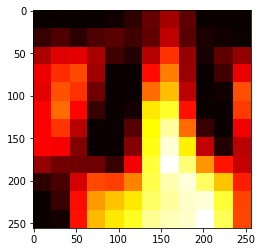

In [150]:
data = heat_map_data[0]
import matplotlib.pyplot as plt

plt.imshow(data, cmap='hot', interpolation='nearest')
plt.show()

In [23]:
import gc
import keras.backend as K

model = None
gc.collect()
K.clear_session()

The following part is for transfer learning.

Notice that X_train, X_test are for original image, x_train, x_test are for transfer learning.

In [96]:
#reload the images, using three channels
X_test = np.empty([len(dat_test), size, size, 3], dtype=np.float32) # preallocate
X_train = np.empty([len(dat_train), size, size, 3], dtype=np.float32) # num_images, img_width, img_height, num_channels

X_test[:,:,:,0]=1
X_train[:,:,:,0]=1

index = 0
t_start = time.time()
for name in dat_test['Image Index']:
    clear_output(wait=True)
    print('working on test {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = keras.preprocessing.image.load_img(file_path+name, grayscale = False)
    #display(img)
    X_test[index,:,:,:] = np.array(img)/255.0-0.5
    index+=1

index = 0
t_start = time.time()
for name in dat_train['Image Index']:
    clear_output(wait=True)
    print('working on train {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = keras.preprocessing.image.load_img(file_path+name, grayscale = False)
    #display(img)
    X_train[index,:,:,:] = np.array(img)/255.5-0.5
    index+=1

working on train 1248, 00024040_000.png, 4.71


In [94]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')

In [97]:
from keras.utils import to_categorical

NUM_CLASSES = 1

(x_train, y_train), (x_test, y_test) = (X_train, y_train), (X_test,y_test)

y_train_ohe = y_train
y_test_ohe = y_test

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1249, 256, 256, 3)
(1249,)
(313, 256, 256, 3)
(313,)


In [98]:
%%time
# from skimage.transform import resize # stupid slow function
from scipy.misc import imresize
import numpy as np

x_train_up = [imresize(x, size=(256,256,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x, size=(256,256,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


(1249, 256, 256, 3)


/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


(313, 256, 256, 3)
CPU times: user 1.49 s, sys: 137 ms, total: 1.63 s
Wall time: 1.85 s


In [99]:
# connect new layers to the output
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = x_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time 
preds = res_no_top.predict(x)
preds.shape


CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 21 µs


(1, 1, 1, 2048)

In [100]:
x_train_up = preprocess_input(x_train)
x_test_up = preprocess_input(x_test)

In [101]:
%%time

x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(1249, 1, 1, 2048)
CPU times: user 22min 19s, sys: 3min 46s, total: 26min 6s
Wall time: 1min 21s


In [110]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               409800    
_________________________________________________________________
dense_16 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 201       
Total params: 450,201
Trainable params: 450,201
Non-trainable params: 0
_________________________________________________________________


In [111]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='mean_squared_error',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))


Train on 1249 samples, validate on 313 samples
Epoch 1/5
1249/1249 [==============================] - 4s 3ms/step - loss: 0.2593 - acc: 0.6485 - val_loss: 0.2125 - val_acc: 0.6965
Epoch 2/5
1249/1249 [==============================] - 0s 76us/step - loss: 0.2298 - acc: 0.6918 - val_loss: 0.2705 - val_acc: 0.3035
Epoch 3/5
1249/1249 [==============================] - 0s 75us/step - loss: 0.2249 - acc: 0.6637 - val_loss: 0.2197 - val_acc: 0.6965
Epoch 4/5
1249/1249 [==============================] - 0s 74us/step - loss: 0.2142 - acc: 0.6926 - val_loss: 0.2144 - val_acc: 0.6965
Epoch 5/5
1249/1249 [==============================] - 0s 76us/step - loss: 0.2162 - acc: 0.6926 - val_loss: 0.2114 - val_acc: 0.6965
